## In the name of God
---
## Deep Learning HW4 - Practical Q3
## Graph Embeddings



In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Graph embedding is a technique employed to transform nodes, edges, and their features into vector space. In this homework, we demonstrate the deepwalk technique on the small version of the Movielens dataset to learn movie embeddings

### Download and Extract the MovieLens dataset

In [2]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()


### Load Movies and Ratings data from csv files

In [3]:
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [4]:
print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)
movies.head()

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# Functions to get movie information
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]

def get_movie_genre_by_id(movieId):
    return list(movies[movies.movieId == movieId].genres)[0]

def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]


### Construct the Movies graph

In this part we construct a graph from movies and rating data. In movie graph an edge is established between two movie nodes within the graph when both movies have received ratings from the same user, with each rating being greater than or equal to the minimum rating threshold, denoted as min_rating. The weight of this edge is determined by the pointwise mutual information (PMI) between the two movies, calculated as follows:

PMI = log(xy) - log(x) - log(y) + log(D)


- xy represents the number of users who have rated both movie x and movie y with a rating greater than or equal to min_rating.
- x represents the count of users who have rated movie x with a rating greater than or equal to min_rating.
- y represents the count of users who have rated movie y with a rating greater than or equal to min_rating.
- D is the total number of movie ratings that meet or exceed the min_rating threshold.

In [7]:
min_rating_threshold = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# select ratings >= min_rating_threshold
rated_movies = ratings[ratings.rating >= min_rating_threshold]
users_movies = list(rated_movies.groupby("userId"))

for group in users_movies:
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])
    # Computer frequency and pair frequency of movies
    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1


In [8]:
min_weight = 10
D = math.log(sum(item_frequency.values()))
movie_graph_edges = []

# Compute weight of each edge based on PMI
for pair in pair_frequency:
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight
    if weight >= min_weight:
        movie_graph_edges.append((x, y, weight))

########################## TODO ##########################
# Create a undirected graph of movies and add weighted edges
# using movie_graph_edges array

movies_graph = nx.Graph()
movies_graph.add_weighted_edges_from(movie_graph_edges)
######################## (THE END) #######################

In [9]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())


Total number of graph nodes: 1405
Total number of graph edges: 40043


In [21]:
########################## TODO ##########################
# find average node degree of movies graph

# Calculate the average node degree
degrees = dict(movies_graph.degree())
avg_node_degree = sum(degrees.values()) / len(degrees)

print("Average node degree:", round(avg_node_degree))
######################## (THE END) #######################

Average node degree: 57


In [23]:
########################## TODO ##########################
# Complete random_walk function to generate random walk sequences of nodes for a particular node
# Start from the start_node
# Get all neighbours of the start_node
# Randomly pick 1 neighbor that does not exist in walk and append it to walk list
# This random node is now your current state

def random_walk(G, start_node, walk_length):
    # starting node
    walk = [start_node]
    current_node = start_node
    for i in range(walk_length-1):
        neighbors = list(G.neighbors(current_node))
        non_visited_neighbors = [n for n in neighbors if n not in walk]
        if len(non_visited_neighbors) == 0:
            break
        next_node = random.choice(non_visited_neighbors)
        walk.append(next_node)
        current_node = next_node
    return walk
######################## (THE END) #######################

In [26]:
########################## TODO ##########################
# Create random walks for train word2vec model
# For each node in movies_graph generate 50 walks
walk_length = 40
num_walks = 50
random_walks = []

for node in tqdm(movies_graph.nodes()):
    for _ in range(num_walks):
        random_walks.append(random_walk(movies_graph, node, walk_length))

######################## (THE END) #######################

100%|██████████| 1405/1405 [02:04<00:00, 11.27it/s]


In [27]:
print("Total number of walks:", len(random_walks))

Total number of walks: 70250


### Model

In [28]:
from gensim.models import Word2Vec

########################## TODO ##########################
# Define Word2vec model in skip-gram mode
# Train model using created random walks
window = 4
min_alpha = 0.0007
epochs=20

# Define Word2Vec model in skip-gram mode
model = Word2Vec(random_walks, vector_size=100, window=window, sg=1, workers=4, epochs=epochs, min_alpha=min_alpha)

# Train the model using created random walks
model.build_vocab(random_walks)
model.train(random_walks, total_examples=model.corpus_count, epochs=model.epochs)

######################## (THE END) #######################

(51872729, 55051320)

### PCA

In [35]:
########################## TODO ##########################
# Select movie_id of 25 mostly rated movies
movie_ids = ratings.groupby(by='movieId').agg(len).sort_values(by='userId', ascending=False).head(25).index.tolist()
######################## (THE END) #######################

In [36]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

def plot_nodes(model, movie_ids):
    X = model.wv[movie_ids]
    movies_genres = [get_movie_genre_by_id(n) for n in movie_ids]

    ########################## TODO ##########################
    # Apply PCA with 2 component on X
    # The shape of result should be : (25, 2)
    result = PCA(n_components=2).fit_transform(X)
    ######################## (THE END) #######################

    # plot pca results
    sns.color_palette("tab10")
    sns.set(rc={'figure.figsize':(10,10)})
    sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=movies_genres)
    plt.legend([],[], frameon=False)

    for i, word in enumerate(movies_genres):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=7)

    plt.show()


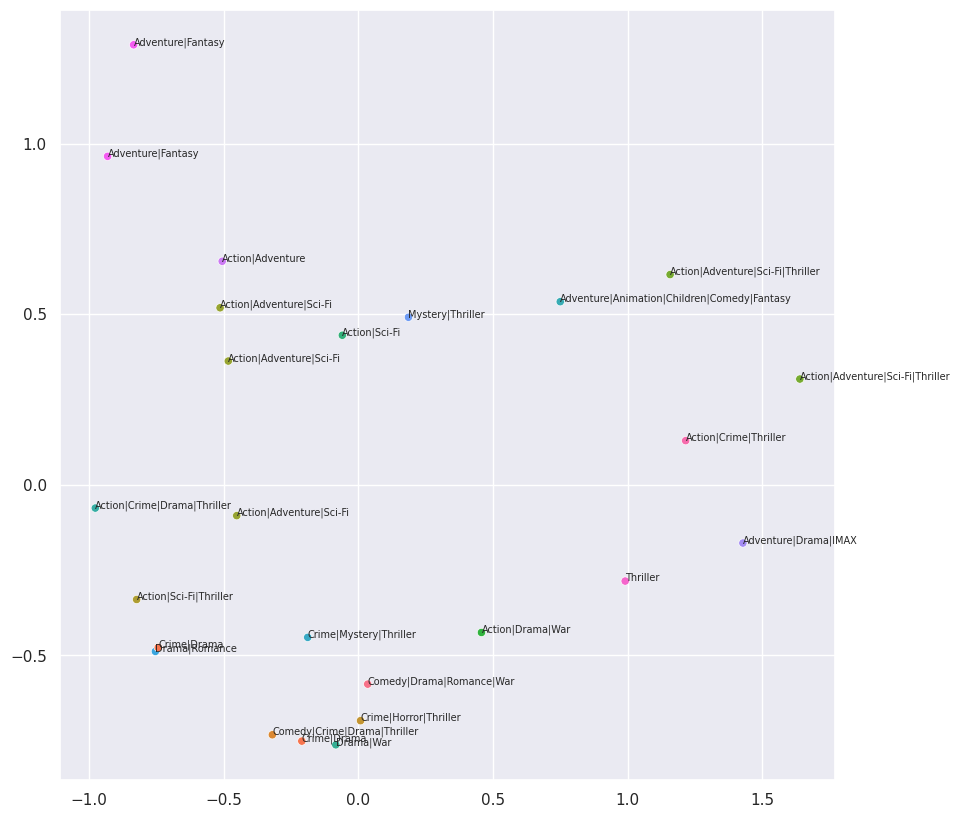

In [37]:
plot_nodes(model, movie_ids)

### Find Similar Movies

In [42]:
def most_similar_movies(model, movie_title, topn):
    ########################## TODO ##########################
    # Find most similar movies using similar_by_word function
    # Return id, title and genre of the similar movies
    movie_id = get_movie_id_by_title(movie_title)
    similar_movies_data = model.wv.most_similar(movie_id, topn=topn)
    similar_movies_data = [
        (id, get_movie_title_by_id(id), sim) for id, sim in similar_movies_data
    ]

    return similar_movies_data
    ######################## (THE END) #######################


In [43]:
most_similar_movies(model, 'Star Wars: Episode IV - A New Hope (1977)', topn=5)

[(1196,
  'Star Wars: Episode V - The Empire Strikes Back (1980)',
  0.711911141872406),
 (1210,
  'Star Wars: Episode VI - Return of the Jedi (1983)',
  0.684612512588501),
 (3510, 'Frequency (2000)', 0.523754358291626),
 (296, 'Pulp Fiction (1994)', 0.5154104232788086),
 (2571, 'Matrix, The (1999)', 0.5146479606628418)]